# Custom Kernel GPR: Extention to Time Evolution



### Previously, we imbued the knowledge that:
- ### The time evolution of heat equation exponentially decays, we can encode this information into our prior-covariance matrix: 
    - ### $A_{ss'}^{-1} =  \exp \left( {-\alpha \left( \frac{n\pi}{L} \right)^2 t}\right) \delta_{s,s'}$   
- ### The Kernel/covariance function is a heuristic  function  which represents how function values at different points are correlated and fully encodes our prior information.
- ### In the 1D heat equation case, we constructed a kernel using temperature measurements at a fixed time, $t$, for some $\mathbf{X} = [x_1,...,x_N]$, so it was supplied a dataset $[T(t,x_1),..., T(t,x_N)]$. THe Kernel is given as follows:
    - ### $K(x,x') = \langle f(\mathit{X})f(\mathit{X'}) \rangle  =\sum_{s,s' = 1}^{S}A_{ss'}^{-1} T_s(\mathit{X}) T_{s'}(\mathit{X'})$, where $x \in (x_1,...,x_N)$.
### The goal of this project is, instead of sampling different temperatures at a fixed time to predict the entire temperature distrbution at some time $t$, we will sample at different positions and  times to predict the entire time evolution of temperature at a point.   Now we will extend it to find the correlation between temperatures with different time measurements, $T(t_i,x_i)$ and $T(t_j,x_j)$. This means the prior no longer has an exponential term, and should be 1 to represent maximum variance: 
- ### $A_{ss'}^{-1} =  \delta_{s,s'}$ 
- ### because $A_{ss'}^{-1} $ is diagonal, it is isomorphic to vectors in $\bf{R^{N}}$, so we can represent $\mathit{Z} = [A_{1,1'}^{-1}, ..., [A_{N,N'}^{-1}]]$
###  We want our kernel function to capture the correlation of the temperature measurements at $(t,x)$, with $\mathit{Z} = [A_{1,1'}^{-1}, ..., [A_{N,N'}^{-1}]]$. lets define $\mathit{X} = (t,x)$ and $\mathit{X'} = (t',x')$: 
$$
\begin{align}
K((t,x),(t',x')) &= K(\mathit{X},\mathit{X'}) = \langle f(\mathit{X}) f (\mathit{X'}) \rangle \\
              &=\sum_{s,s'=1}^{S} Z_s \exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 t}\right)\exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 t'}\right) \sin\left(\frac{s\pi x}{L}\right)\sin\left(\frac{s\pi x'}{L}\right)\\
              
              &=\sum_{s,s=1}^{S} Z_s\exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 (t+t'
              )}\right) \sin\left(\frac{s\pi x}{L}\right)\sin\left(\frac{s\pi x'}{L}\right)
\end{align}
$$
### thus our resulting kernel function is given by:
$$
K(\mathit{X},\mathit{X'})=\sum_{s=1}^{S} \exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 (t+t'
              )}\right) \sin\left(\frac{s\pi x}{L}\right)\sin\left(\frac{s\pi x'}{L}\right)
$$

### given the dataset $(t_{\alpha}, x_{\alpha}, T(t_{\alpha},x_{\alpha}), \sigma_{\alpha}^2  )$, the entry of the kernel matrix given the data is:
$$
\bar{K}_{i,j,} = K(\mathit{X},\mathit{X'}) + \sigma_{x}^2\delta_{i,j} + \sigma^2_{t}\delta_{i,j} = K(\mathit{X},\mathit{X'}) +\sigma^2\delta_{i,j}
$$
### where we combined the noise: $\sigma^2 = \sigma_{x}^2+ \sigma^2_{t}$. We therefore have our posterior expectation of our measurement:
$$
\langle T(\mathit{X})  \rangle = \sum_{i,j} K(\mathit{X},\mathit{X_i'}) [\bar{K}]_{i,j}^{-1} T_{j}
$$


## Heat Decay plot:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time # To compare performance
rng = np.random.default_rng(2)

def heat_decay(coeffs_list: np.ndarray,
               modes: int,
               x_point: float,
               time_array: np.ndarray,
               length: float,
               alpha: float)->np.ndarray:
  """
  Simulates the 1D heat equation at a specific point x using Fourier series
  and plots its decay over time. 

  Assumes boundary conditions u(0, t) = u(L, t) = 0.
  The solution is u(x, t) = Σ [c_n * sin(n * π * x / L) * exp(-(n * π / L)² * a * t)]
  """
  a: float = alpha
  L: float = length
  N: int = modes
  c_n: np.ndarray = coeffs_list
  n_values = np.arange(1, N + 1)

  # Pre-calculate terms involving n, L, alpha, x_point -> shape: (modes,)
  term_coeff = n_values * np.pi / L
  sin_term = np.sin(term_coeff * x_point)
  exp_decay_rate = -(term_coeff**2) * a
  exp_term = np.exp(exp_decay_rate[:, np.newaxis] * time_array[np.newaxis, :])
  all_terms = c_n[:N, np.newaxis] * sin_term[:, np.newaxis] * exp_term
  u_at_x_point: np.ndarray = np.sum(all_terms, axis=0)

  return u_at_x_point


def heat_field(coeffs_list: np.ndarray,
               modes: int,
               x_array: np.ndarray,
               time_array: np.ndarray,
               length: float,
               alpha: float) -> np.ndarray:
    """
    Calculates the 1D heat equation field u(x, t) over grids of x and t
    using Fourier series and vectorized operations.

    Assumes boundary conditions u(0, t) = u(L, t) = 0.
    The solution is u(x, t) = Σ [c_n * sin(n * π * x / L) * exp(-(n * π / L)² * a * t)]
    """
    a: float = alpha
    L: float = length
    N: int = modes
    c_n: np.ndarray = coeffs_list
    n_values = np.arange(1, N + 1)

    term_coeff = n_values * np.pi / L         
    exp_decay_rate = -(term_coeff**2) * a         

    # Sin term, Exp term
    sin_term_grid = np.sin(term_coeff[:, np.newaxis] * x_array[np.newaxis, :])
    exp_term_grid = np.exp(exp_decay_rate[:, np.newaxis] * time_array[np.newaxis, :])

    # Combine: c_n * sin_term * exp_term for all n, x, t
    all_terms_grid = (
        c_n[:N, np.newaxis, np.newaxis] *    # Coefficients broadcast
        sin_term_grid[:, :, np.newaxis] *    # Sin term broadcast along time axis
        exp_term_grid[:, np.newaxis, :]      # Exp term broadcast along space axis
    )

    # Sum over modes (axis 0) to get the final field 
    temp_field = np.sum(all_terms_grid, axis=0)

    return temp_field

def heat_single_point(coeffs_list, modes, x, t, length, alpha):
     val = heat_field(coeffs_list, modes, np.array([x]), np.array([t]), length, alpha)
     return val.item() 

def evolve_temp(coeffs_list: np.ndarray,
                modes: int,
                Positions: any,
                times: any,
                length: float,
                alpha: float) -> np.ndarray: 
    if isinstance(Positions, float) and isinstance(times,np.ndarray):  # Check if Positions is a single float
        temp_array: np.ndarray = heat_decay(coeffs_list, modes, Positions, times, length, alpha)
        return temp_array
    elif isinstance(Positions, np.ndarray) and isinstance(times,np.ndarray):  # Check if Positions is a numpy array
        temp_grid: np.ndarray = heat_field(coeffs_list, modes, Positions, times, length, alpha)
        return temp_grid
    elif isinstance(Positions, float) and isinstance(times,float):
        temp = heat_single_point(coeffs_list, modes,Positions, times, length, alpha)
        return temp
    else:
        raise ValueError("Positions must be either a float or a numpy.ndarray.")

[-0.73088957 -0.73510152 -0.75124786 -0.71862612 -0.66871191 -0.4962406 ]
Vectorized function time: 0.000691 seconds


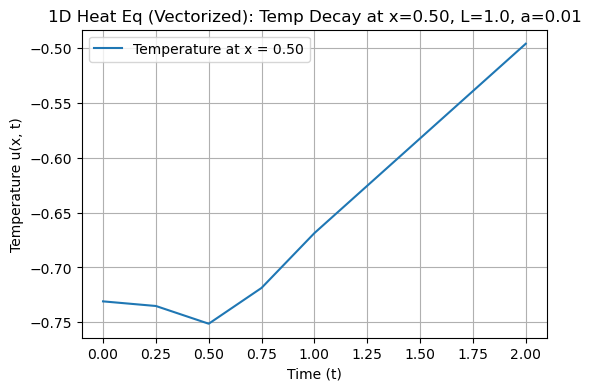

In [ ]:
# Parameters
L = 1.0
modes = 10   
alpha = 0.01  
t_end = 2.0
x_meas = L / 2
num_t_steps = 1000  
coeffs = rng.uniform(-1, 1, modes)

# Time points for simulation 
times = np.array([0,0.25,0.5,0.75,1,2]) 

# Time the original version
start_time_vec = time.time()
temperature_decay_vec = evolve_temp(coeffs, modes, x_meas , times, L, alpha)
print(temperature_decay_vec)
end_time_vec = time.time()
print(f"Vectorized function time: {end_time_vec - start_time_vec:.6f} seconds")


# Plotting 
plt.figure(figsize=(6, 4))
plt.plot(times, temperature_decay_vec, label=f'Temperature at x = {x_meas:.2f}')
plt.xlabel("Time (t)")
plt.ylabel("Temperature u(x, t)")
plt.title(f"1D Heat Eq (Vectorized): Temp Decay at x={x_meas:.2f}, L={L}, a={alpha}")
plt.legend()
plt.grid(True)
plt.show()



### we begin by calculating the prior-covariance matrix: $A_{s,s'} = \delta_{s,s'}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)

def prior_covar(N_modes: float):
    ''' 
    Calculates the covariance matrix:
        A_{ss'} =delta_{s,s'}
    '''
    n: float = N_modes

    return np.eye(n,n)

N = 2
print(prior_covar(N))


[[1. 0.]
 [0. 1.]]


### then use the prior-covariance matrix to construct the kernel function:
$$
\begin{align}
K(\mathit{X},\mathit{X'})&=\sum_{s=1}^{S} \exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 (t+t'
              )}\right) \sin\left(\frac{s\pi x}{L}\right)\sin\left(\frac{s\pi x'}{L}\right)\\
K((t,x), (t',x'))&=\sum_{s=1}^{S} \exp \left( {-\alpha \left( \frac{s\pi}{L} \right)^2 (t+t'
              )}\right) \sin\left(\frac{s\pi x}{L}\right)\sin\left(\frac{s\pi x'}{L}\right)
\end{align}
$$ 

## Kernel Function:


In [ ]:
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
rng = np.random.default_rng(1) #

def kernel_func(Length: float,
                alpha: float,
                modes: int,
                coord1: list,
                coord2: list)-> float:
    """
    Computes the space-time kernel value K((t1,x1), (t2,x2)) for the 1D heat
    equation, assuming an identity prior covariance on initial coefficients (Z_s=1).\n
        K((t1,x1), (t2,x2)) = \sum_s Z_s  exp(-alpha(s\pi/L)**2  (t1+t2)) sin(s\pi(x1)/L)  sin((s\pi(x2)/L)
    convention: coord = [time, postion]
    """
    L: float = Length
    N: int = modes
    t1 = coord1[0];x1 = coord1[1]
    t2 = coord2[0];x2 = coord2[1]
    # Precompute constants based on modes
    s_vals = np.arange(1, N + 1) 
    arg = s_vals * np.pi / L    
    k_sq_s = arg**2             

    # Calculate terms for the sum
    exp_decay = np.exp(-alpha * k_sq_s * (t1 + t2)) 
    sin_sx1 = np.sin(arg * x1)                   
    sin_sx2 = np.sin(arg * x2)       

    # Compute the kernel value by summing the product over modes
    # Z_s = 1 is implicit here
    kernel_value = np.sum(exp_decay * sin_sx1 * sin_sx2)

    return kernel_value

def kernel_matrix(Length: float,
                alpha: float,
                modes: int,
                coord1: list[np.ndarray,np.ndarray],
                coord2: list[np.ndarray,np.ndarray]):
    ''' 
    Computes the space-time kernel value K((t,x), (t',x')) for the 1D heat
    equation, assuming an identity prior covariance on initial coefficients (Z_s=1).\n
        K((t,x), (t',x')) = \sum_s exp(-alpha(s*pi/L)**2 * (t+t')) * sin(s*pi*x/L) * sin(s*pi*x'/L)
    '''
    L: float = Length
    a: float = alpha
    N: int = modes
    t1_array = coord1[0];x1_array = coord1[1]
    t2_array = coord2[0];x2_array = coord2[1]
    s_vals = np.arange(1,N+1) * np.pi / L

    t_sum = t1_array[:, None] + t2_array[None, :]   
    exp_decay = np.exp(-a * s_vals[:, None, None]**2 * t_sum)   
    sin_sx1 = np.sin(s_vals[:, None] * x1_array)   
    sin_sx2 = np.sin(s_vals[:, None] * x2_array)   

    # Correct broadcasting: align dimensions explicitly
    kernel_matrix = np.sum(
        exp_decay[:, :, :] * sin_sx1[:, :, None] * sin_sx2[:, None, :],
        axis=0
    )
    return kernel_matrix


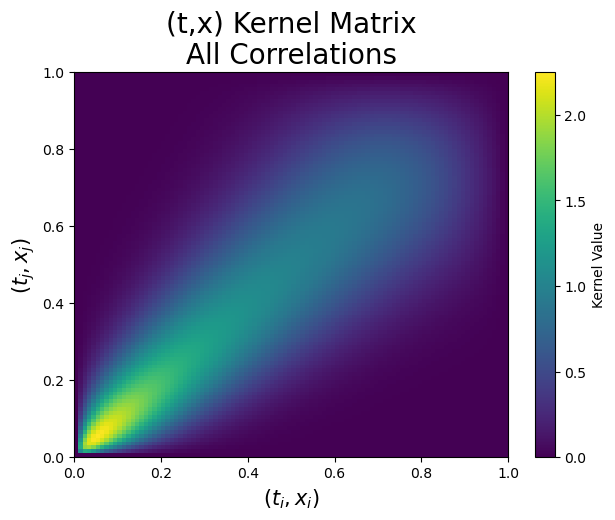

In [ ]:
# Example parameters
L = 1.0
a = 0.01
N = 20
steps = 100
tmax = 2
t_data = np.linspace(0, tmax, steps)   
x_data = np.linspace(0, L, steps)   

# Compute the kernel matrix
K_matrix = kernel_matrix(L, a, N, [t_data, x_data], [t_data, x_data])

# Plot the kernel matrix
plt.figure(figsize=(7, 5))
plt.imshow(K_matrix, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Kernel Value")
plt.title("(t,x) Kernel Matrix\nAll Correlations",size=20)
plt.xlabel(r"$(t_i,x_i)$",size=15)
plt.ylabel(r"$(t_j,x_j)$",size=15)
plt.show()


### Calculating the Covariance of the data-set:
### given the dataset $(t_{\alpha}, x_{\alpha}, T(t_{\alpha},x_{\alpha}), \sigma_{\alpha}^2  )$, the entry of the kernel matrix given the data is:
$$
\bar{K}_{i,j,} = K(\mathit{X_i},\mathit{X_j'}) + \sigma^2\delta_{i,j}
$$


## Data Covariance matrix: 

In [14]:
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
rng = np.random.default_rng(1) #

def data_covar(Length: float,
               alpha: float,
               modes: int,
               meas_point1: list[np.ndarray,np.ndarray],
               meas_point2: list[np.ndarray,np.ndarray],
               sigma: float,
               kernel_matrix: callable):
    ''' 
    Computes the data covariance matrix:\n
        Kbar[a,b] = K((t_a,x_a),(t_b,x_b)) + sigma^2 * 1
    '''
    L: float = Length
    a: float = alpha
    N: int = modes
    kernel: np.ndarray = kernel_matrix(L, a, N, meas_point1, meas_point2)
    covariance: np.ndarray = kernel + sigma**2 * np.eye(kernel.shape[0])
    return covariance

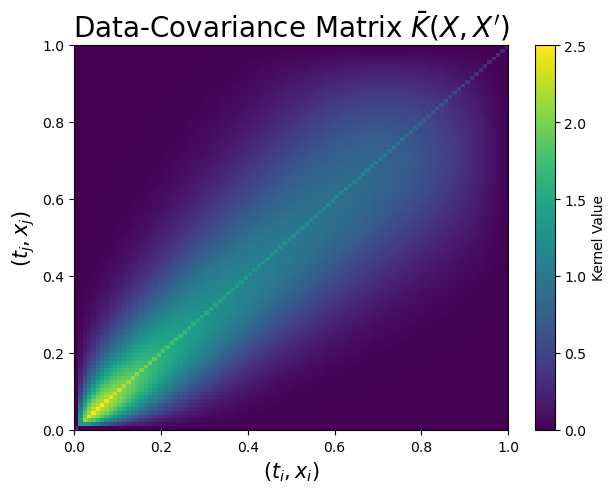

In [ ]:
# Example parameters
L = 1.0
a = 0.01
modes = 20
tmax = 2
sigma = 0.5
steps = 100
t_data = np.linspace(0, tmax, steps)  
x_data = np.linspace(0, L, steps)  

# Compute the kernel matrix
Kbar = data_covar(L, a, modes, [t_data, x_data], [t_data, x_data],sigma, kernel_matrix)

# Plot the kernel matrix
plt.figure(figsize=(7, 5))
plt.imshow(Kbar, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Kernel Value")
plt.title(r"Data-Covariance Matrix $\bar{K}(X,X')$",size=20)
plt.xlabel(r"$(t_i,x_i)$",size=15)
plt.ylabel(r"$(t_j,x_j)$",size=15)
plt.show()


### Posterior expectation of our measurement:
$$
\begin{align}
\langle T(\mathit{Y})  \rangle &= \sum_{i,j} K(\mathit{Y},\mathit{X_i}) [\bar{K}]_{i,j}^{-1} T_{j} \\
\langle T(\mathit{Y})  \rangle &= K(Y, X)^T \  [\bar{K}]^{-1}  \ T

\end{align}
$$

### Where: 
- ### $\mathit{Y}$ represents a prediction point: $\mathit{Y} = (t,x)$
- ### $\mathit{X_i} = (t_{\text{data}}, x_{\text{data}})$ are points where the measurements were taken
- ### $\bar{K}^{-1}$ is the inverse of the Data covariance matrix $K(X_i, X_j)+\sigma^2 \delta_{i,j}$ 
- ### $T$ is a vector of temperature measurements


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) 

def mean_prediction(Length: float,
                    alpha: float,
                    modes: int,
                    t_values_pred: np.ndarray,
                    x_values_pred: np.ndarray,
                    measurement_coords: list[np.ndarray, np.ndarray],
                    Kbar: np.ndarray,
                    meas_temps: np.ndarray,
                    kernel_matrix_func: callable) -> np.ndarray:
    """
    Calculates the mean prediction at prediction_point based on measurements.
        <T(X)> =  \sum_{i,j} K(\mathit{X},\mathit{X_i'}) [\bar{K}]_{i,j}^{-1} T_{j}
        <T(X)> = K(X, X_meas)^T @ Kbar_inv @ T_meas
    where X = prediction_point, X_meas are measurement_points, T_meas is Temp_data.
    #NOTE:
    prediction_point: list, # The single point X = [t, x] for prediction
    measurement_points: list[np.ndarray, np.ndarray], # The points where measurements were taken [t_array, x_array]
    Kbar: np.ndarray,         # Data covariance matrix K(X_i, X_j) + noise
    Temp_data: np.ndarray,    # Measured temperatures T_j
    """
    L = Length # Assign to local variables for clarity if preferred
    a = alpha
    N = modes
    # Calculate weights (Kbar_inv @ meas_temps)
    Kbar_inv = np.linalg.inv(Kbar)
    weights = Kbar_inv @ meas_temps
    prediction_coords = [t_values_pred, x_values_pred] 

    # Calculate K_star_matrix K(X_pred, X_meas)
    K_star_matrix = kernel_matrix_func(L, a, N, prediction_coords, measurement_coords)

    # Calculate all mean predictions at once
    predictions = K_star_matrix @ weights  
    return predictions


supplied measurements
 [0.30252086 0.48791456 0.41816683 0.35671182 0.30835538]


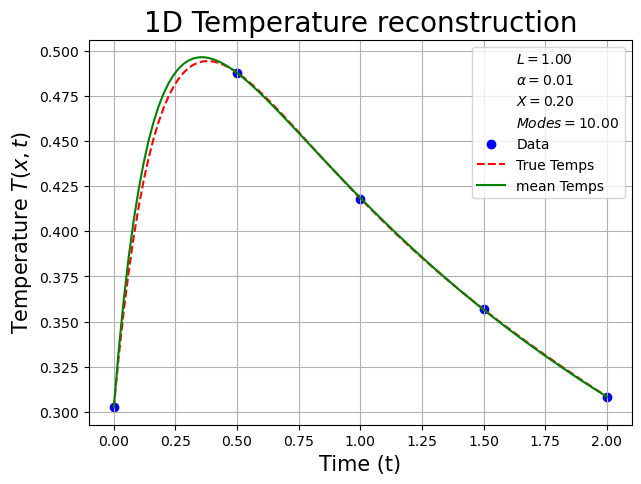

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) 

L = 1.0
alpha = 0.01
modes = 10
sigma = 0.01
tmax = 2
num_meas = 5
num_pred_times = 100                                    
x_meas = L / 5                                          
x_predict = x_meas                                     

# Generate random Fourier coefficients
c_n = rng.uniform(-1, 1, modes)

# Define Measurement Points (e.g., 5 points)
t_data = np.linspace(0, tmax, num_meas)                 
x_data = np.ones(num_meas) * x_meas                     
measurement_coords = [t_data, x_data]

# Times for prediction/plotting
time_vals_pred = np.linspace(0, tmax, num_pred_times)    
x_vals_pred = np.ones(num_pred_times)*x_predict          

# Calculate true temperatures at the prediction points 
true_temps = evolve_temp(c_n, modes, x_predict, 
                        time_vals_pred, L, alpha)

# Calculate temperatures at measurement points
meas_temps = evolve_temp(c_n, modes, x_meas, 
                        t_data, L, alpha)
print("supplied measurements\n",meas_temps)

# precompute data-covariance:
Kbar = data_covar(L, alpha, modes,
                   measurement_coords, 
                   measurement_coords, 
                   sigma, kernel_matrix)

# caculate the predictions at all time values
ave_temps = mean_prediction(
    Length=L,
    alpha=alpha,
    modes=modes,
    t_values_pred=time_vals_pred,
    x_values_pred=x_vals_pred,
    measurement_coords=measurement_coords,
    Kbar=Kbar,
    meas_temps=meas_temps,
    kernel_matrix_func=kernel_matrix  
)

# Plotting 
plt.figure(figsize=(7, 5))
plt.plot([],[],color='none',label=rf"$L={L:.2f}$")
plt.plot([],[],color='none',label=rf"$\alpha={alpha:.2f}$")
plt.plot([],[],color='none',label=rf"$X={x_predict:.2f}$")
plt.plot([],[],color='none',label=rf"$Modes={modes:.2f}$")
plt.scatter(t_data,meas_temps, color='b', label='Data')
plt.plot(time_vals_pred, true_temps,color='r',linestyle='--', label=f'True Temps')
plt.plot(time_vals_pred, ave_temps,color='g', label=f'mean Temps')
plt.xlabel("Time (t)", size=15)
plt.ylabel(r"Temperature $T(x, t)$", size=15)
plt.title(f"1D Temperature reconstruction", size=20)
plt.legend()
plt.grid(True)
plt.show()

 

### Posterier Variance:
$$
\begin{align}
\sigma_{\text{post}}^2(\mathit{X}) &=  K(\mathit{X},\mathit{X} ) + \sum_{i,j} K(\mathit{X},\mathit{X_i'}) \bar{K}_{i,j}^{-1}K(\mathit{X_j'},\mathit{X})\\
\sigma_{\text{post}}^2((t,x)) &=  K((t,x), (t,x)) + \sum_{i,j} K((t,x), (t_i,x_i) ) \bar{K}_{i,j}^{-1}K((t_j,x_j),(t,x))
\end{align}
$$
### where $\mathit{X}$ is the prediction cooridinate $(t,x)$ and $\mathit{X'_i}$ are the coordinates used in measurements
 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
rng = np.random.default_rng(1)

# --- Combined Prediction Function (Mean and Variance) ---
def GPR_prediction(Length: float,
                    alpha: float,
                    modes: int,
                    t_values_pred: np.ndarray,
                    x_values_pred: np.ndarray,
                    measurement_coords: list[np.ndarray, np.ndarray],
                    meas_temps: np.ndarray,
                    sigma: float, # Noise sigma is needed for Kbar
                    kernel_func: callable,
                    kernel_matrix_func: callable) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculates the GP posterior mean and variance at multiple prediction points.
    """
    L = Length
    a = alpha
    N = modes
    num_pred = t_values_pred.shape[0]

    # Mean Calculation 
    Kbar = data_covar(L, a, N, measurement_coords, measurement_coords, sigma, kernel_matrix_func)
    Kbar_inv = np.linalg.inv(Kbar)
    weights = Kbar_inv @ meas_temps

    prediction_coords = [t_values_pred, x_values_pred]
    K_star_matrix = kernel_matrix_func(L, a, N, prediction_coords, measurement_coords)  
    mean_pred = K_star_matrix @ weights 

    # Variance reduction term: diag(K_star @ Kbar_inv @ K_star.T)
    k_diag = np.zeros(num_pred)
    for p in range(num_pred):
        pred_point = [t_values_pred[p], x_values_pred[p]]
        k_diag[p] = kernel_func(L, a, N, pred_point, pred_point)

    temp_matrix = K_star_matrix @ Kbar_inv  
    variance_reduction = np.sum(temp_matrix * K_star_matrix, axis=1) 
    variance_pred = k_diag - variance_reduction

    
    std_dev_pred = np.sqrt(variance_pred)

    return mean_pred, variance_pred, std_dev_pred


Supplied measurements (with noise):
 [0.63506087 0.48063467 0.31122424 0.36211858]

Combined prediction took: 0.0025 seconds


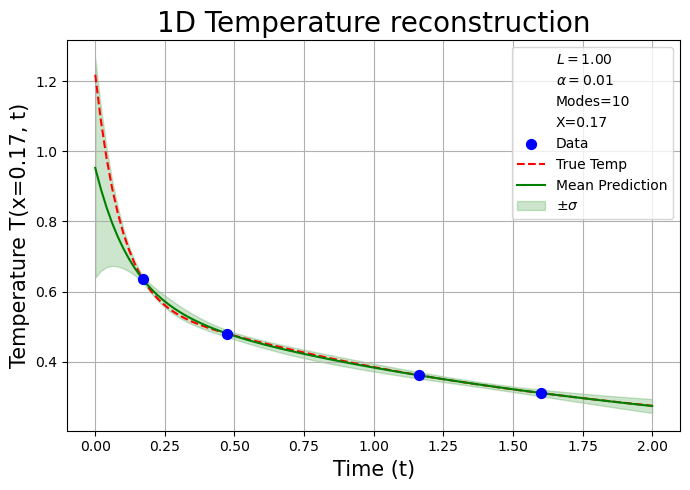

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
rng = np.random.default_rng(1)

L = 1.0
alpha = 0.01
modes = 10
sigma = 0.01 # Measurement noise std dev
tmax = 2
num_pred_times = 100
num_meas = 4
x_observe = L / 6
x_decay = x_observe

# Generate random Fourier coefficients
c_n = rng.uniform(-1, 1, modes)

# define measurement points 
rng_measurements = np.random.default_rng(3)
t_data = rng_measurements.uniform(0, tmax, size=num_meas)
x_data = np.ones(num_meas) * x_observe
measurement_coords = [t_data, x_data]

# Calculate analytic Temperatures and Measured Temperatures 
time_vals_pred = np.linspace(0, tmax, num_pred_times)
x_vals_pred = np.ones(num_pred_times) * x_decay
analytic_temps = evolve_temp(c_n, modes, x_decay, time_vals_pred, L, alpha)
meas_temps = evolve_temp(c_n, modes, x_observe, t_data, L, alpha)
print("Supplied measurements (with noise):\n", meas_temps)

# GPR Prediction 
start_time = time.time()

mean_predictions, variance_predictions, std_dev_predictions = GPR_prediction(
    Length=L,
    alpha=alpha,
    modes=modes,
    t_values_pred=time_vals_pred,
    x_values_pred=x_vals_pred,
    measurement_coords=measurement_coords,
    meas_temps=meas_temps,
    sigma=sigma, 
    kernel_func=kernel_func,
    kernel_matrix_func=kernel_matrix
)

end_time = time.time()
print(f"\nCombined prediction took: {end_time - start_time:.4f} seconds")

# Plotting with STDEV
plt.figure(figsize=(7, 5)) # Slightly wider figure
plt.plot([],[],color='none',label=rf"$L={L:.2f}$")
plt.plot([],[],color='none',label=rf"$\alpha={alpha:.2f}$")
plt.plot([],[],color='none',label=f"Modes={modes}")
plt.plot([],[],color='none',label=f"X={x_decay:.2f}")

plt.scatter(t_data, meas_temps, color='blue', label='Data', zorder=5, s=50, marker='o')
plt.plot(time_vals_pred, analytic_temps, color='red', linestyle='--', label=f'True Temp')
plt.plot(time_vals_pred, mean_predictions, color='green', label=f'Mean Prediction')
lower_bound = mean_predictions -  std_dev_predictions
upper_bound = mean_predictions +  std_dev_predictions
plt.fill_between(time_vals_pred, lower_bound, upper_bound, color='green', alpha=0.2, label=r'$\pm \sigma$')

plt.xlabel("Time (t)",size=15)
plt.ylabel(f"Temperature T(x={x_decay:.2f}, t)",size=15)
plt.title(f"1D Temperature reconstruction",size=20)
plt.legend(fontsize=10) 
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def plot_3d_field(ax, X, T, Z, title, xlabel, ylabel, zlabel, cmap, vmin=None, vmax=None, colorbar_label=None, scatter_data=None, scatter_size=100, alpha=1.0):
    """
    Plots a 3D field on the given axes.
    """
    surf = ax.plot_surface(X, T, Z, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_zlabel(zlabel, size=14)
    ax.set_title(title, size=20)
    cbar = plt.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
    if colorbar_label:
        cbar.set_label(colorbar_label, size=14)
    if scatter_data:
        x_data, t_data, z_data = scatter_data
        ax.scatter(x_data, t_data, z_data, color='b', s=scatter_size, depthshade=True, label='Data')
        ax.legend(fontsize=16) 
    return ax


Total prediction points: 10000
Generated 20 measurements.
Starting GP prediction on the grid...
GP prediction finished in 0.38 seconds.
Calculating true temperature field...
True field calculation finished in 0.00 seconds.
Generating plots...


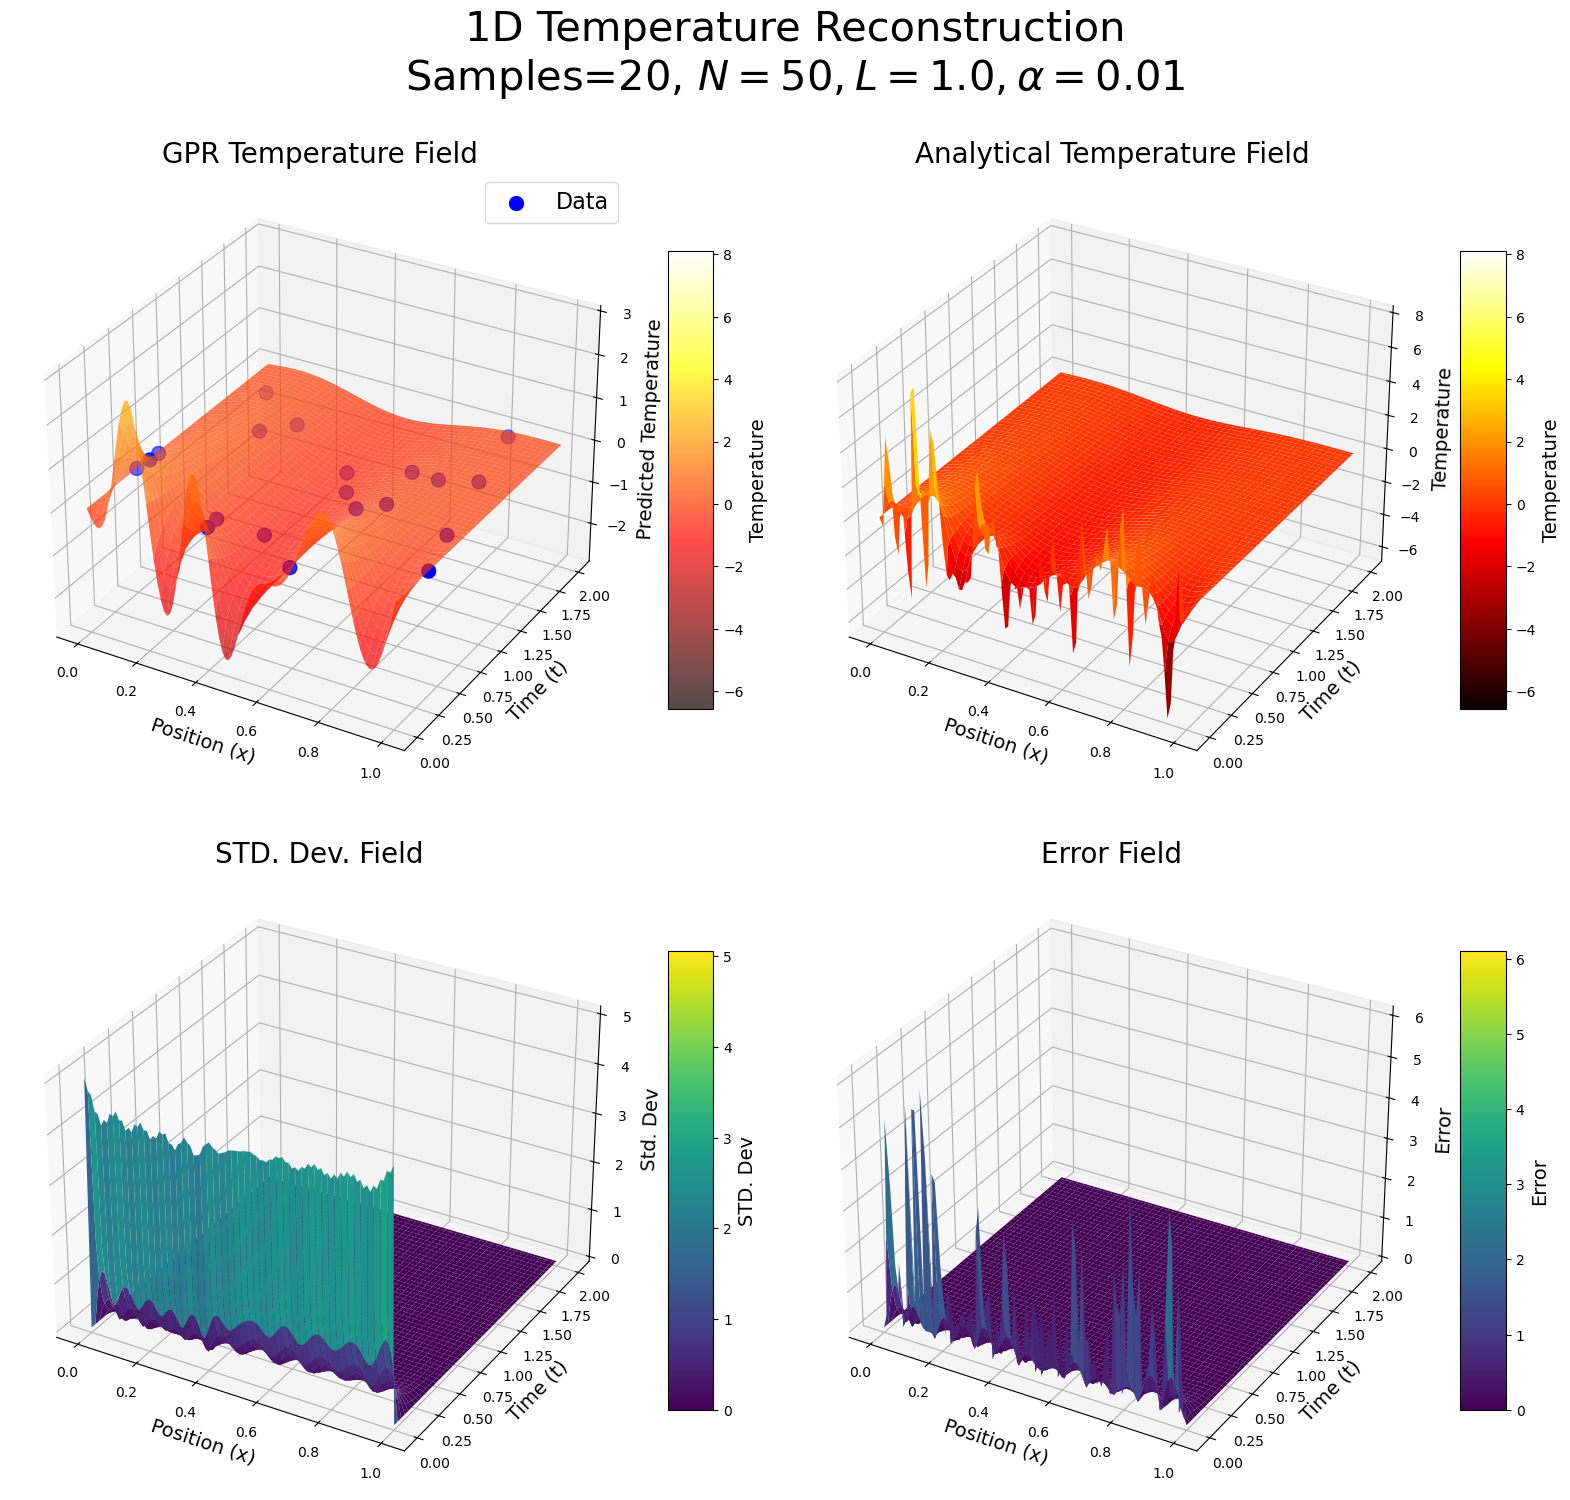

Done.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import time
rng = np.random.default_rng(2)

L = 1.0
alpha = 0.01
modes = 50
sigma = 0.01
tmax = 2
num_meas = 20


# Prediction Grid 
num_x_points = 100
num_t_points = 100
x_pred_grid_vals = np.linspace(0, L, num_x_points); t_pred_grid_vals = np.linspace(0, tmax, num_t_points) 
X_mesh, T_mesh = np.meshgrid(x_pred_grid_vals, t_pred_grid_vals, indexing='ij')

# Flatten the grid coordinates for the prediction function
x_flat = X_mesh.flatten();t_flat = T_mesh.flatten()
print(f"Total prediction points: {x_flat.shape[0]}")

# Define Measurement Points 
t_data = rng.uniform(0, tmax, num_meas)
# x_data = rng.uniform(0, L, num_meas)
x_data = np.linspace(0,L, num_meas)
measurement_coords = [t_data, x_data]

c_n = rng.uniform(-1, 1, modes) # fourier coefficients
meas_temps = np.array([
    evolve_temp(c_n, modes, x_data[i], t_data[i], L, alpha)
    for i in range(num_meas)])

print(f"Generated {num_meas} measurements.")

# Calculate Prediction on the Grid 
print("Starting prediction on the grid...")

start_time = time.time()
mean_flat, variance_flat, std_dev_flat = GPR_prediction(
    Length=L,
    alpha=alpha,
    modes=modes,
    t_values_pred=t_flat,
    x_values_pred=x_flat,
    measurement_coords=measurement_coords,
    meas_temps=meas_temps,
    sigma=sigma,
    kernel_func=kernel_func,
    kernel_matrix_func=kernel_matrix
)
end_time = time.time()

print(f"GP prediction finished in {end_time - start_time:.2f} seconds.")
 
mean_pred_grid = mean_flat.reshape(X_mesh.shape)  
std_dev_pred_grid = std_dev_flat.reshape(X_mesh.shape)
# Calculate True Temperature Field on the Grid using heat_field
print("Calculating true temperature field...")

start_time = time.time()
true_temp_grid = heat_field(c_n, modes, x_pred_grid_vals, t_pred_grid_vals, L, alpha)
end_time = time.time()
print(f"True field calculation finished in {end_time - start_time:.2f} seconds.")


# Plotting
print("Generating plots...")
fig = plt.figure(figsize=(16, 16))
plt.suptitle(f"1D Temperature Reconstruction\n"+rf"Samples={num_meas}, $N={modes},L={L},\alpha={alpha}$", size=30)

min_temp = min(np.min(true_temp_grid), np.min(mean_pred_grid))
max_temp = max(np.max(true_temp_grid), np.max(mean_pred_grid))
minstdev = min(np.min(std_dev_pred_grid), np.min(std_dev_pred_grid))
maxstdev = max(np.max(std_dev_pred_grid), np.max(std_dev_pred_grid))

# Plot 1: Mean Prediction
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
plot_3d_field(
    ax1, X_mesh, T_mesh, mean_pred_grid, 
    title="GPR Temperature Field", xlabel="Position (x)", ylabel="Time (t)", zlabel="Predicted Temperature",
    cmap="hot", vmin=min_temp, vmax=max_temp, colorbar_label="Temperature",
    scatter_data=(x_data, t_data, meas_temps), scatter_size=100, alpha=0.7
)

# Plot 2: True Temperature Field
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
plot_3d_field(
    ax2, X_mesh, T_mesh, true_temp_grid, 
    title="Analytical Temperature Field", xlabel="Position (x)", ylabel="Time (t)", zlabel="Temperature",
    cmap="hot", vmin=min_temp, vmax=max_temp, colorbar_label="Temperature"
)

# Plot 3: STDEV Field
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
plot_3d_field(
    ax3, X_mesh, T_mesh, std_dev_pred_grid, 
    title="STD. Dev. Field", xlabel="Position (x)", ylabel="Time (t)", zlabel="Std. Dev",
    cmap="viridis", vmin=minstdev, vmax=maxstdev, colorbar_label="STD. Dev"
)

# Plot 4: Error Field
error_field = np.abs(mean_pred_grid - true_temp_grid)
min_err, max_err = np.min(error_field), np.max(error_field)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
plot_3d_field(
    ax4, X_mesh, T_mesh, error_field, 
    title="Error Field", xlabel="Position (x)", ylabel="Time (t)", zlabel="Error",
    cmap="viridis", vmin=min_err, vmax=max_err, colorbar_label="Error"
)

plt.tight_layout()
plt.show()
print("Done.")
